In [1]:
import cv2
import numpy as np
import os 

from skimage.feature import peak_local_max
#from skimage.morphology import watershed
from scipy import ndimage
from scipy.signal import find_peaks

from IPython.display import clear_output
from PIL import Image

# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')
#sys.path.append('/eno/jdfeathe/pepe/')

from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff, rectMask, mergeMasks
from pepe.preprocess import cannyEdgeDetection, laplacianEdgeDetection, sobelEdgeDetection, applyFilter

from pepe.analysis import gSquared
from pepe.tracking import houghCircle, circularKernelFind, convCircle
from pepe.topology import findPeaks1D, findPeaksMulti, findPeaks2D

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

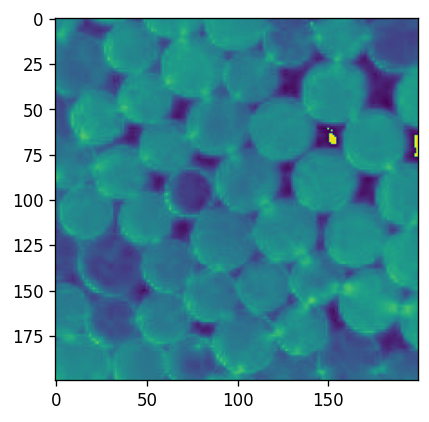

In [103]:
#dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'
dataFolder = '/eno/jdfeathe/DATA/'
image = checkImageType(dataFolder + 'test_farnaz_data.jpg')
#image = image.astype(np.float64) / 255
image = image.astype(np.uint8)

# Create a cross-shaped channel, with some parts on the ends
# For light correction, we want two separate images, one vertical and one horizontal
#maskXBounds = [430, 755] # Found manually
#maskYBounds = [338, 668] # Found manually
#maskArr = crossMask(image.shape, xlim=np.array(maskXBounds), ylim=np.array(maskYBounds))

image = image[200:400, 400:600]

lightCorr = lightCorrectionDiff(image[:,:,0]).astype(np.uint8)

maskArr = np.ones(image.shape, dtype=np.uint8)

plt.imshow((image*maskArr)[:,:,0] + lightCorr)
plt.show()

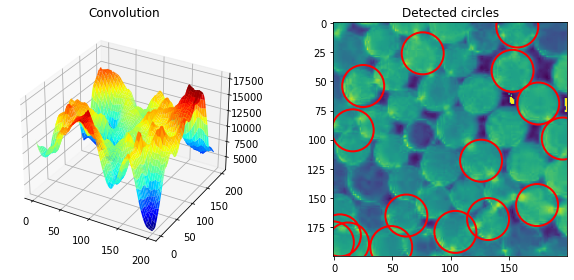

In [132]:
radius = 18
particleCenters, particleRadii = convCircle(image[:,:,0]*maskArr[:,:,0] + lightCorr, radius, invert=False,
                                            debug=True, intensitySoftmax=2., peakDownsample=1,
                                            offscreenParticles=True, radiusTolerance=None, minPeakPrevalence=.25)

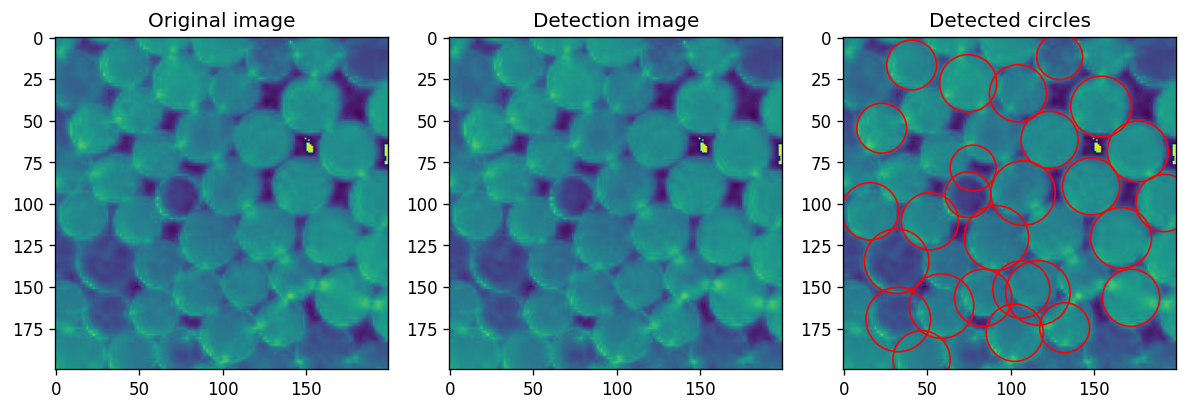

(array([[156.5, 172.5],
        [134.5,  31.5],
        [ 61.5, 123.5],
        [161.5,  58.5],
        [120.5,  91.5],
        [120.5, 166.5],
        [177.5, 102.5],
        [ 89.5, 148.5],
        [153.5, 116.5],
        [ 68.5, 176.5],
        [169.5,  32.5],
        [ 27.5,  74.5],
        [ 33.5, 104.5],
        [ 54.5,  22.5],
        [ 93.5, 107.5],
        [ 41.5, 154.5],
        [104.5,  15.5],
        [110.5,  51.5],
        [156.5,  83.5],
        [ 16.5,  40.5],
        [ 94.5,  74.5],
        [174.5, 132.5],
        [ 11.5, 129.5],
        [151.5, 106.5],
        [193.5,  46.5],
        [ 99.5, 192.5],
        [ 78.5,  77.5]], dtype=float32),
 array([17.2, 19.4, 17.2, 19.4, 19.4, 18.3, 17.2, 17.2, 19.4, 18.3, 19.4,
        17.2, 17.2, 15. , 19.4, 18.3, 17.2, 17.2, 17.2, 15. , 13.8, 15. ,
        13.8, 17.2, 17.2, 17.2, 13.8], dtype=float32))

In [117]:
houghCircle(image[:,:,0]*maskArr[:,:,0] + lightCorr, radius=[12, 20], draw=True,
            edgeDetection=None, accumulatorThreshold=15, cannyEdgeThreshold=50)

In [6]:
%timeit convCircle(image[:,:,0]*maskArr[:,:,0], radius, intensitySoftmax=2., peakDownsample=20)

545 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit houghCircle(image[:,:,0]*maskArr[:,:,0], 155, radiusTolerance=20, draw=False, edgeDetection=None, accumulatorThreshold=22, cannyEdgeThreshold=90)

418 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit circularKernelFind(image[:,:,0]*maskArr[:,:,0], radius, radius, debug=False)

389 ms ± 4.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


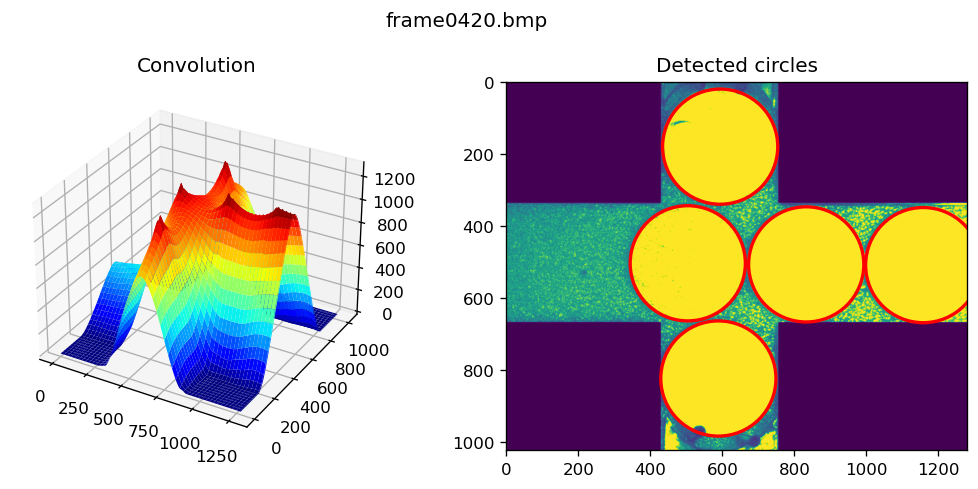

In [5]:
dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'
files = os.listdir(dataFolder + '2022-02-02_Wide/')
radius = 160
files = np.sort(files)
save = True

# Cut down to only the first hundred
#files = files[:100]

for i in range(len(files)):
    image = checkImageType(dataFolder + '2022-02-02_Wide/' + files[i])
    
    clear_output(wait=True)
    particleCenters, particleRadii = convCircle(image[:,:,0]*maskArr[:,:,0], radius,
                                                draw=True, intensitySoftmax=1.2, peakDownsample=20,
                                                offscreenParticles=False, radiusTolerance=None)
    fig = plt.gcf()
    fig.suptitle(files[i])
    fig.tight_layout()
    if save:
        plt.savefig('../images/convolution_test/' + files[i][:-4] + '.png')
    plt.show()
   
if save:
    imageFiles = os.listdir('../images/convolution_test/')
    imageFiles = np.sort(imageFiles)
    imageFiles = [img for img in imageFiles if img[-3:] == 'png']
    fps = 40

    images = [None for i in range(len(imageFiles))]
    for i in range(len(imageFiles)):
        images[i] = Image.open('../images/convolution_test/' + imageFiles[i])

    images[0].save('../images/convolution_test/convolution.gif', save_all=True, append_images=images[1:], duration=fps, optimize=False, loop=1)

In [7]:
imageFiles = os.listdir('../images/convolution_test/')
imageFiles = np.sort(imageFiles)
imageFiles = [img for img in imageFiles if img[-3:] == 'png']
fps = 40

images = [None for i in range(len(imageFiles))]
for i in range(len(imageFiles)):
    images[i] = Image.open('../images/convolution_test/' + imageFiles[i])
    
images[0].save('../images/convolution_test/convolution.gif', save_all=True, append_images=images[1:], duration=fps, optimize=False, loop=1)

In [136]:
a = np.array([1, 2, 3, 4])
a[np.array([0,0,1])]

array([1, 1, 2])

## Radius Variation Testing

In [2]:
def genTrainingImages(imgSize, N, minCircles=1, maxCircles=4, minRadius=125, maxRadius=200, overlap=False, noise=1):
    img = np.zeros((N, *imgSize))
    numCircles = np.random.randint(minCircles, maxCircles, size=N)
    
    circleCentersX = np.random.randint(0, imgSize[0], size=N)
    circleCentersY = np.random.randint(0, imgSize[1], size=N)
    
    Y = np.arange(imgSize[0]).reshape((imgSize[0], 1)) # Column vector
    X = np.arange(imgSize[1]).reshape((1, imgSize[1])) # Row vector
    
    # Generate the circles
    for i in range(N):
        radii = np.random.uniform(minRadius, maxRadius, size=numCircles[i])
        print(radii)
        j = 0
        while j < numCircles[i]:
            yC, xC = np.random.randint(0, imgSize[0]), np.random.randint(0, imgSize[1])
            newCircle = ((X - xC)**2 + (Y - yC)**2) < radii[j]**2
            # Make sure circles don't overlap
            if np.max(img[i] + newCircle) == 1:
                img[i] += newCircle
                j += 1
                
    # Now add noise
    noisyImg = img + np.random.uniform(0.01*noise, noise, size=img.shape)
    
    return noisyImg, img

[53.97951697 54.88592594 52.03898278 56.07146178 58.89771016 55.06953291
 58.89757433 59.63426925 58.4921393  58.79906599 53.1100128  51.22747196
 59.59272411 50.35540105 52.52975563 51.18459452]


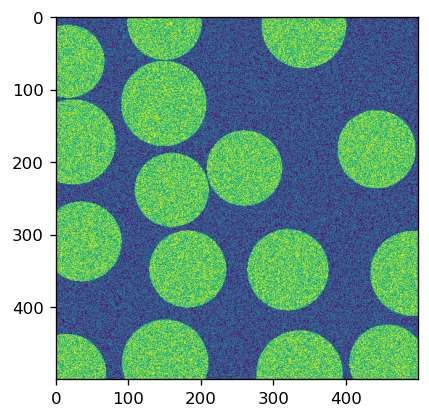

In [11]:
circles = genTrainingImages([500, 500], 1, 15, 20, minRadius=50, maxRadius=60, noise=1)

plt.imshow(circles[0][0])
plt.show()

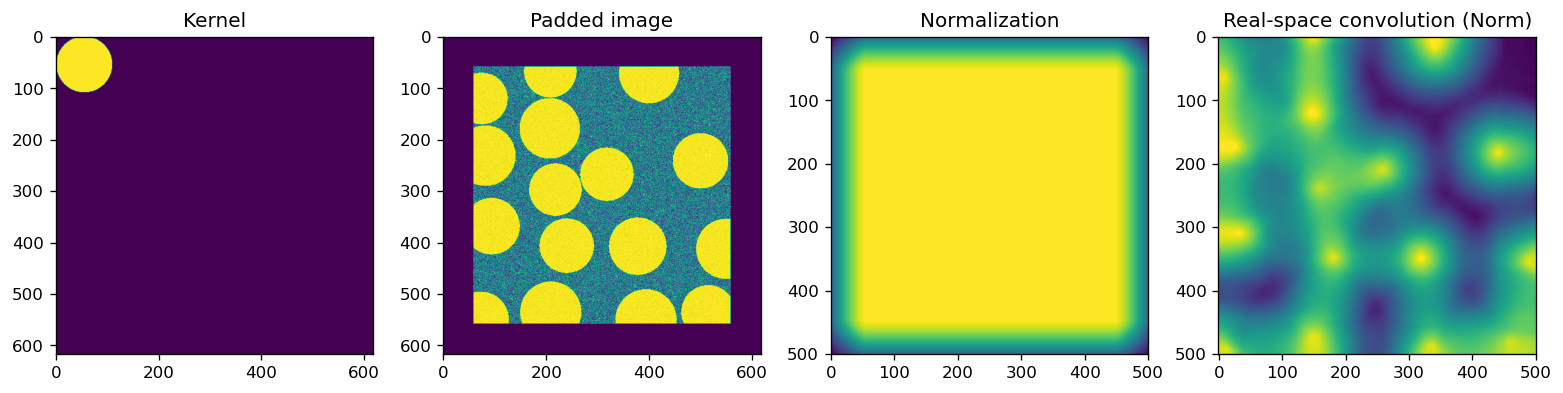

[(172, 13), (349, 319), (311, 35), (121, 149), (14, 343), (0, 150), (184, 441), (67, 0), (472, 150), (348, 180), (354, 487), (488, 335), (492, 14), (210, 258), (482, 459), (239, 163)]
[172  13]


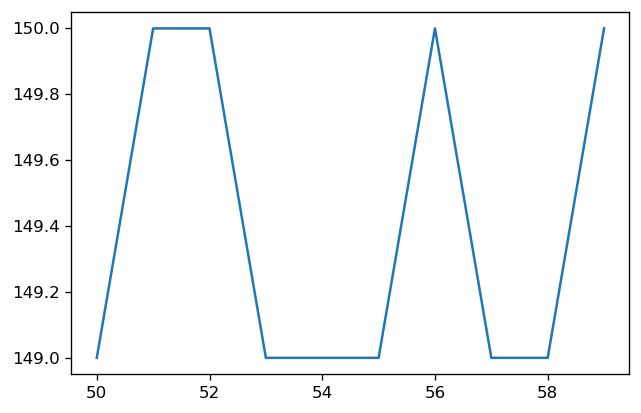

[349 319]


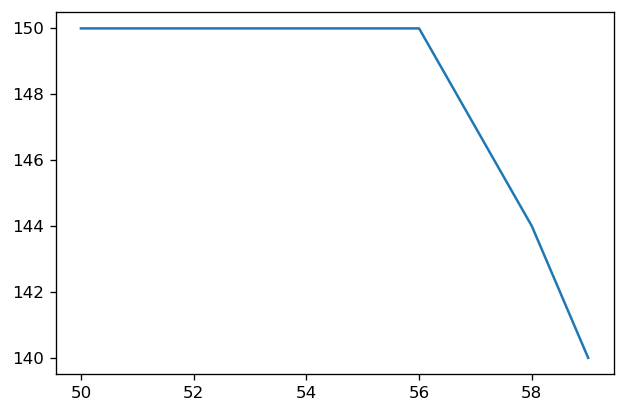

[311  35]


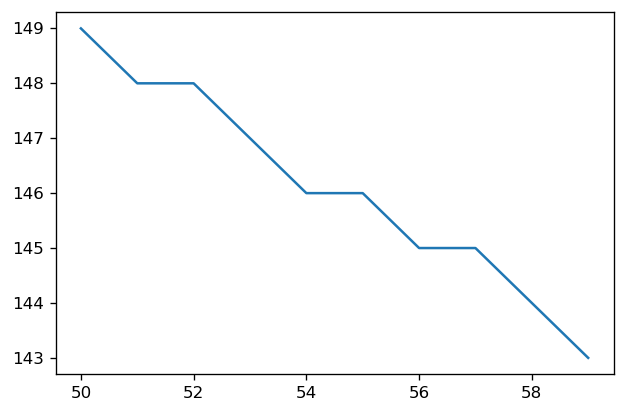

[121 149]


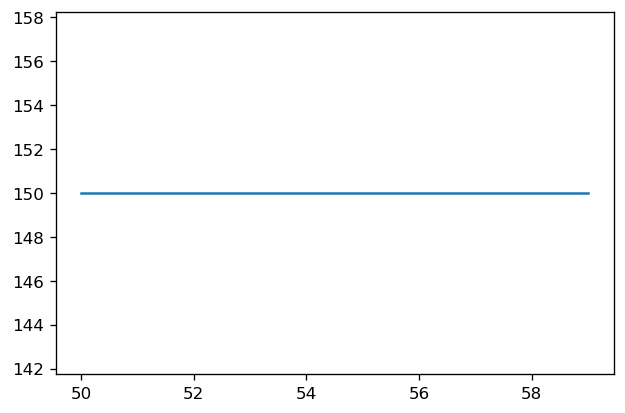

[ 14 343]


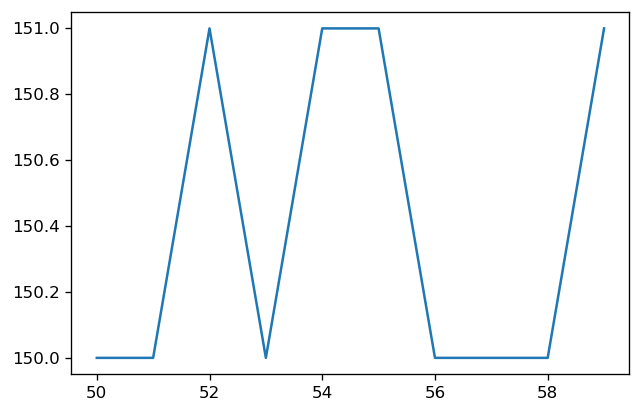

[  0 150]
[-56. 149.]


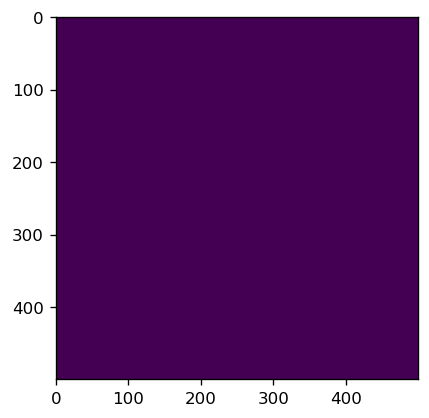

[-59. 149.]


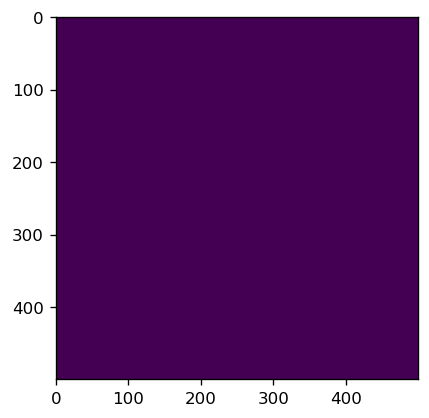

[-60. 149.]


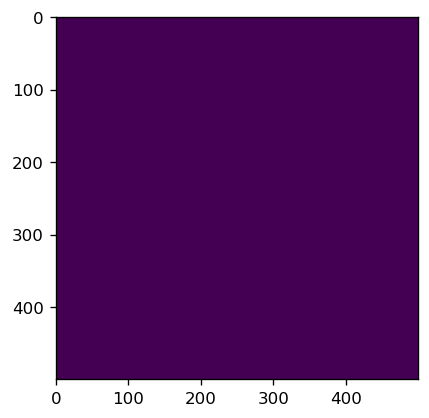

[-63. 149.]


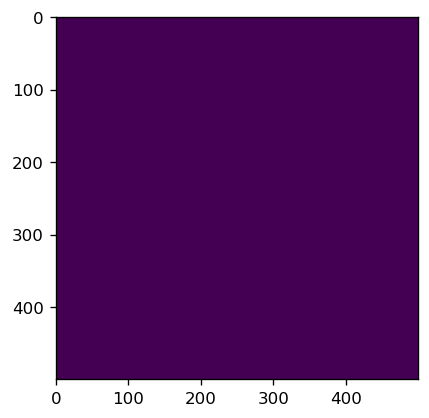

[-64. 149.]


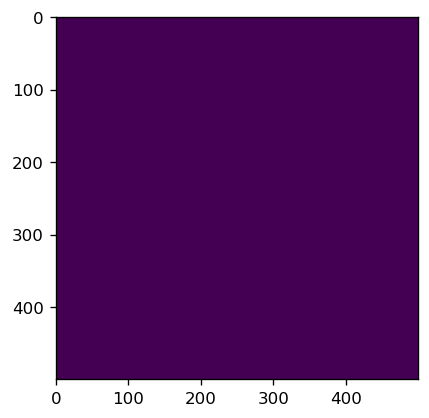

[-66. 149.]


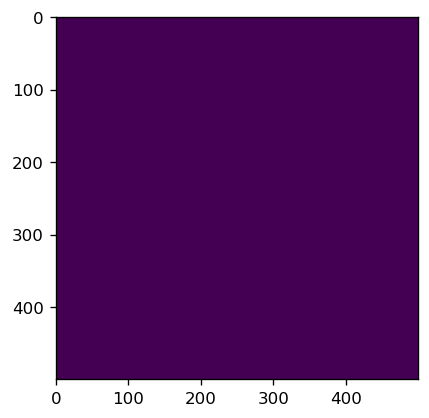

[-67. 149.]


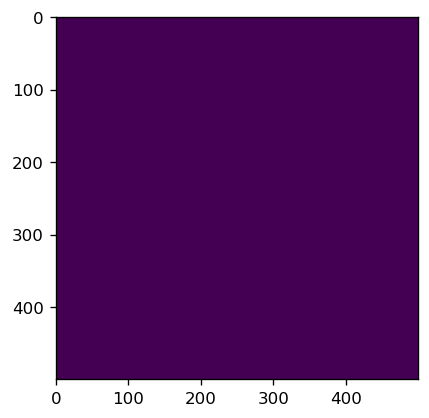

[-68. 149.]


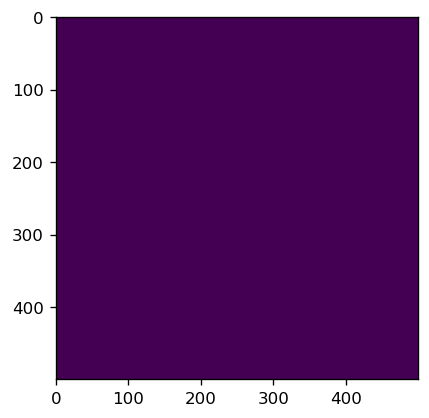

[-69. 148.]


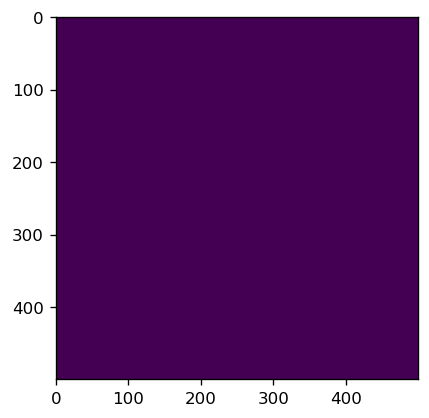

[-70. 146.]


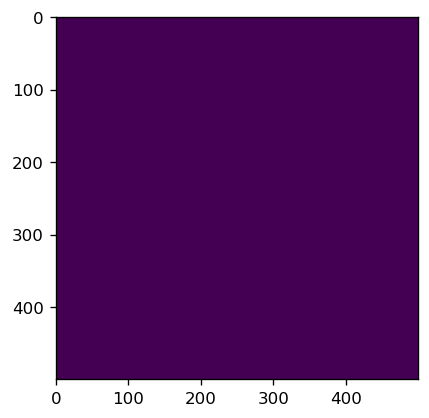

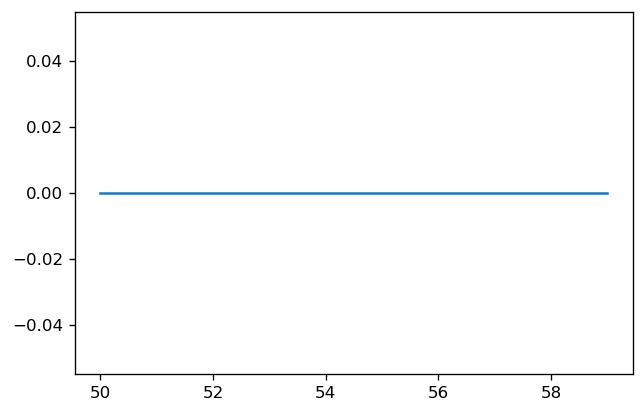

[184 441]


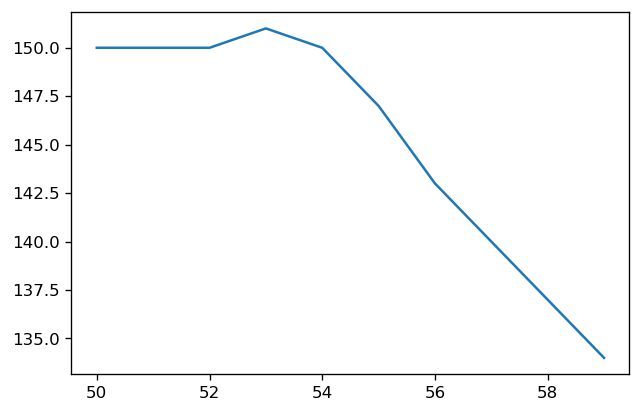

[67  0]
[ 62. -51.]


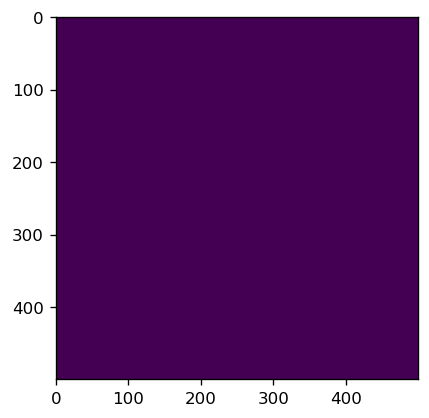

[ 62. -54.]


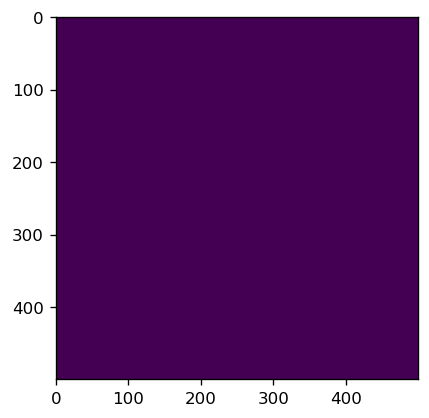

[ 61. -59.]


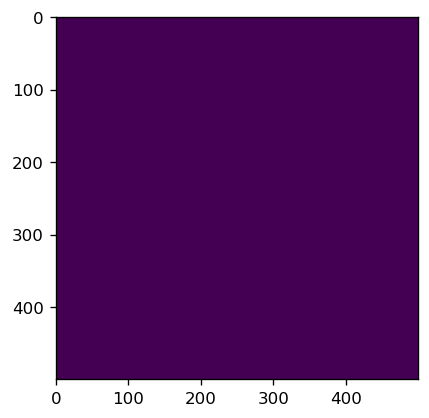

[ 61. -63.]


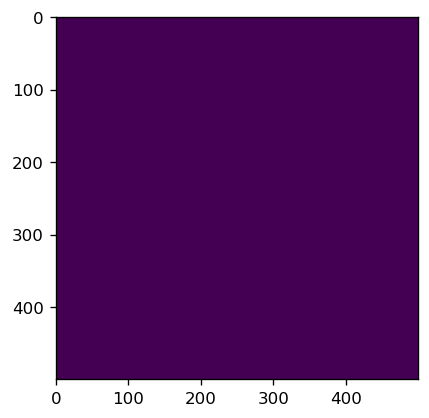

[ 62. -64.]


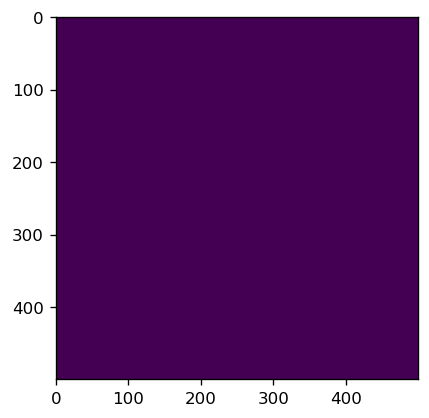

[ 67. -66.]


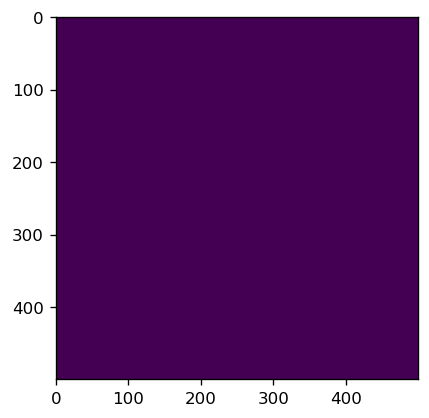

[ 67. -67.]


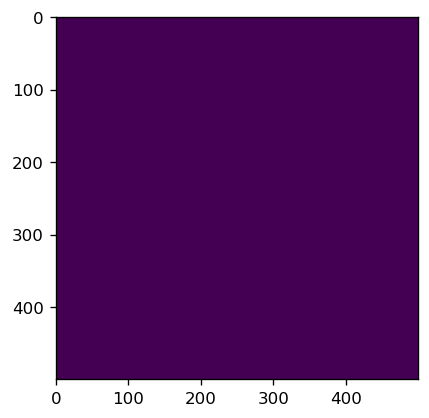

[ 68. -68.]


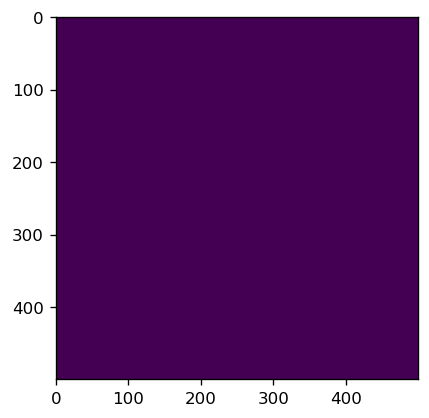

[ 67. -69.]


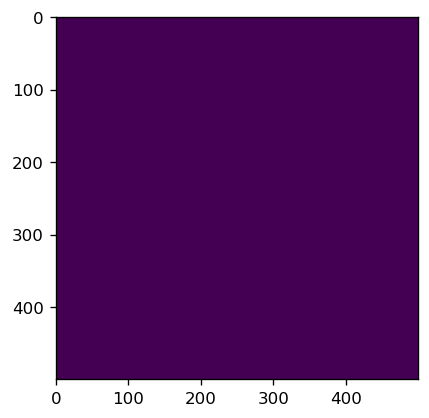

[ 67. -70.]


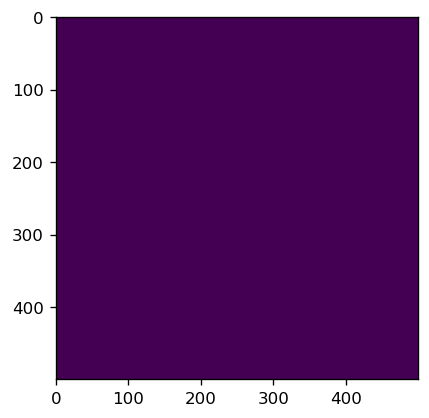

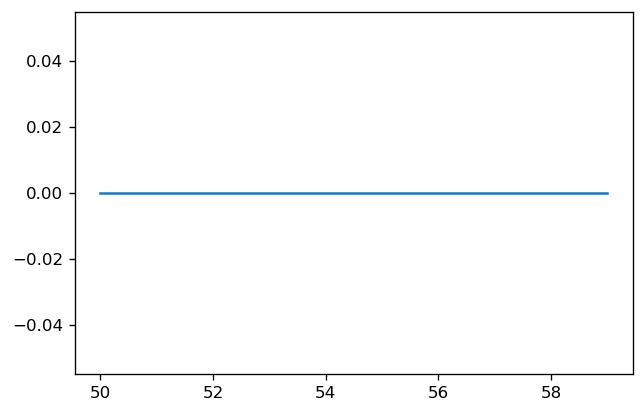

[472 150]


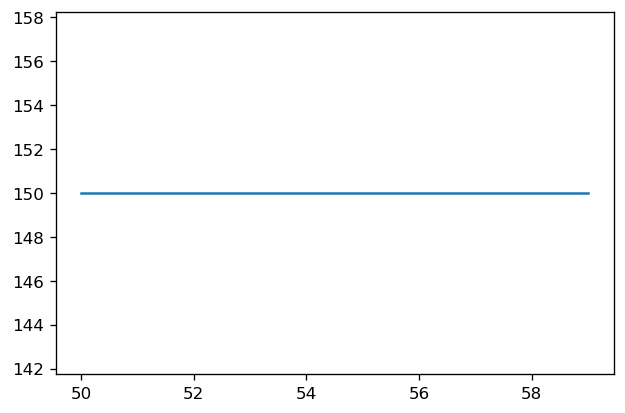

[348 180]


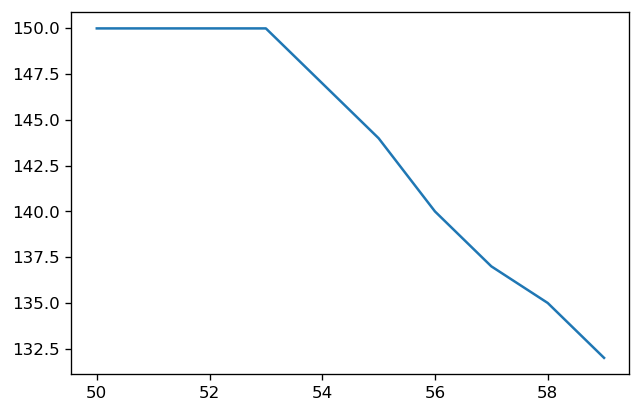

[354 487]


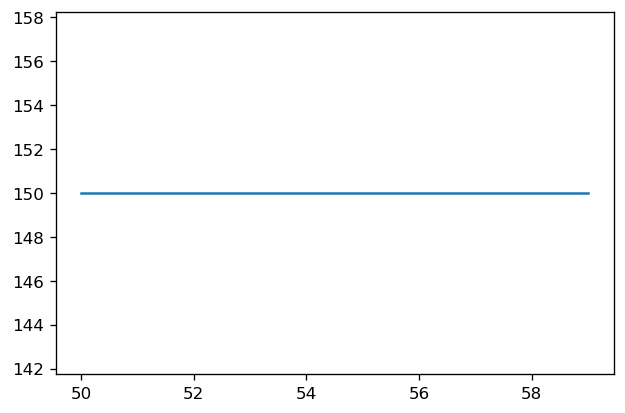

[488 335]


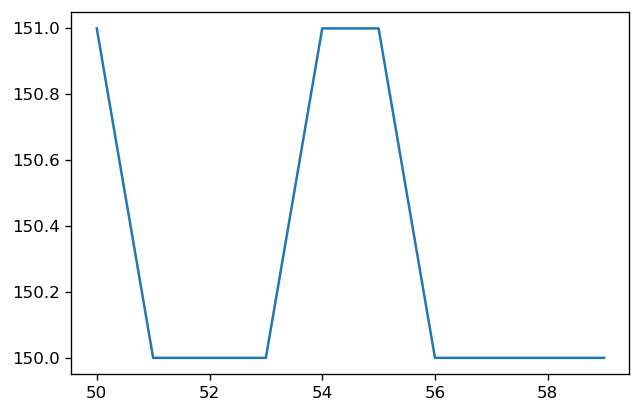

[492  14]


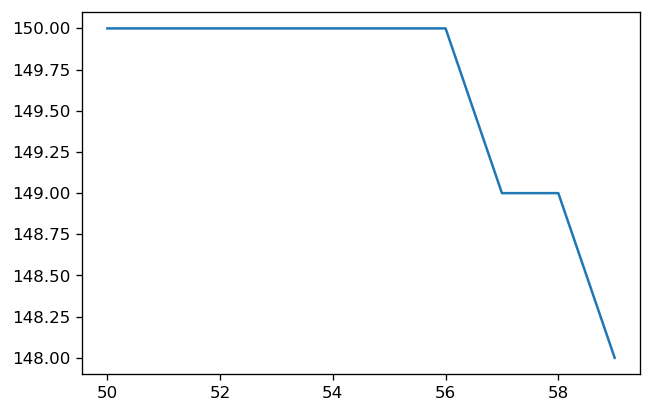

[210 258]


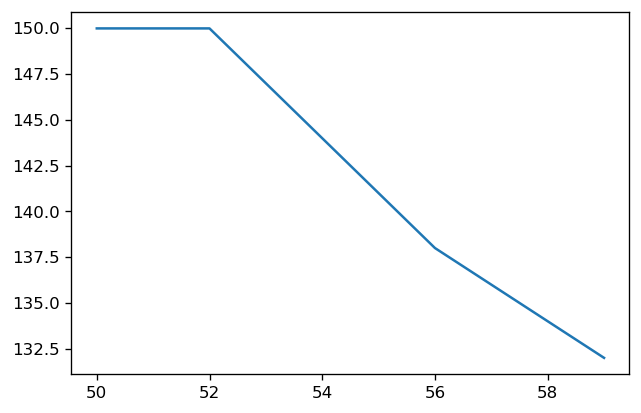

[482 459]


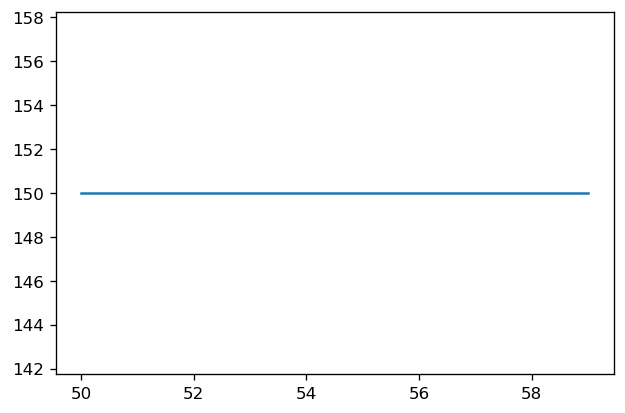

[239 163]


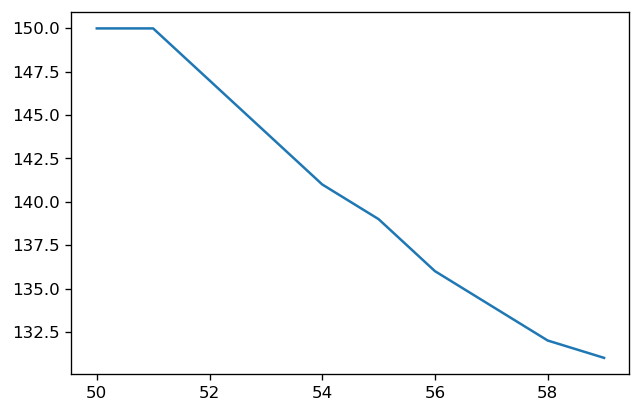

[59 56 50 59 59 59 53 59 59 53 59 55 56 52 59 51]


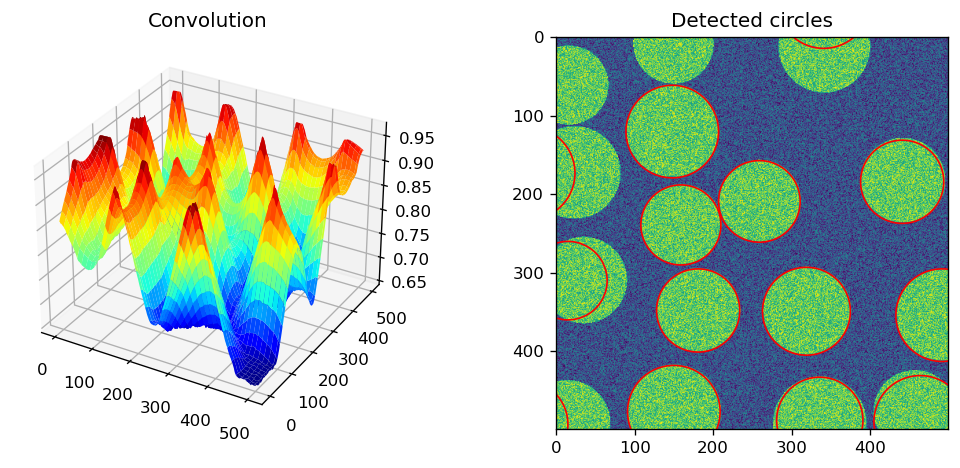

In [13]:
detCenters, detRadii = convCircle(circles[0][0], 55, debug=True, radiusTolerance=5, minPeakPrevalence=.3, peakDownsample=1)
print(detRadii)

## 